# Substructures & substructure filters

In addition to the descriptors introduced in the previous notebooks, determining whether a given chemical structure contains specific substructures or structural patterns can provide additional ways to characterize a set of structures, and filter it if desired. Also, substructure search is a core feature in most chemical databases. When you prepare chemical databases of your own, you should definitely consider implementing it :)

Now, for our usual boilerplate:

# What to do

 - again, load your own ligand set as well as DrugBank
 - try out the SMARTS-based substructure search on your own data
 - familiarize yourself with the notion of substructure search, if you haven't already from the lectures or other courses. Have a look at the linked resources.
 - Here, we tested our set and DrugBank for the -COOH functional group. Define your own SMARTS substructure, prefereably some functional group like -NH2, =O, etc. Run the substructure as a query on your own set, and against DrugBank. Any interesting outcome?
 - Have a look at PAINS. If you don't know them already, read up on the concept in the linked resources.
 - Scan your set for PAINS, have a look of how many of your structures have those substructures, and which ones. If you filter those structures out, how much would your set of structures shrink?
 - Bonus question: you might have noticed that extensive substructure searches take some time. Based on your experience and/or linked materials, any tips on why that might be? Any ideas on possible pre-filtering methods to speed things up?

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import csv

RDKit WARNING: [00:24:04] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# load your own set, and DrugBank :)
with open('DRD1.csv', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    drd1_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader if m['Smiles'] != ''] # nektere jsou prazdne

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

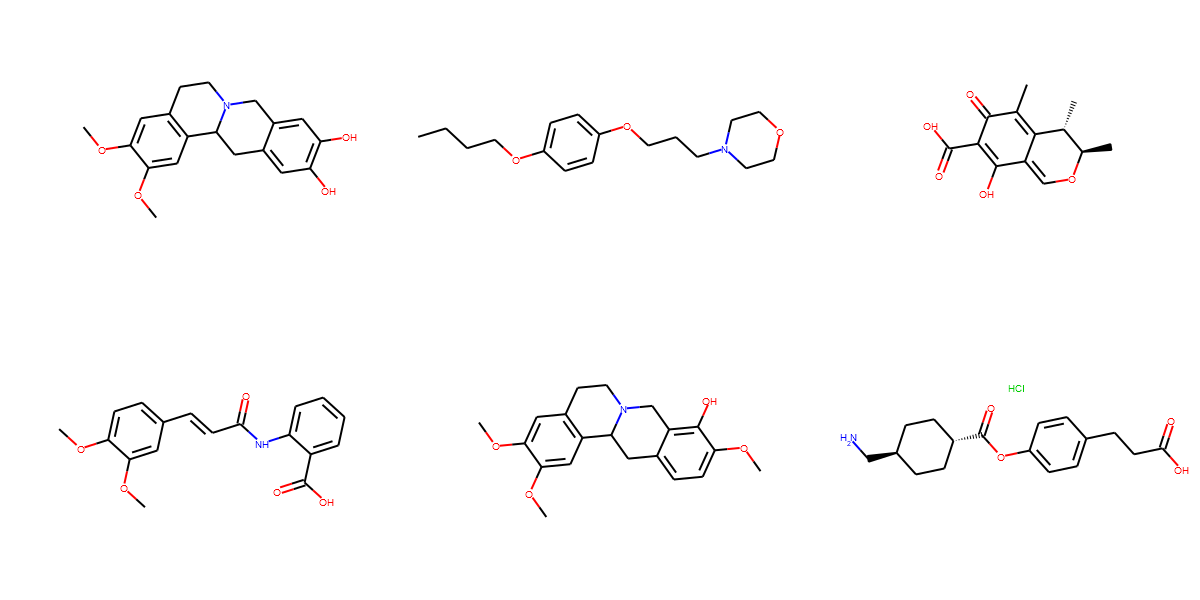

In [3]:
Draw.MolsToGridImage([drd1_ligands[x] for x in [0,3,56,300, 500, 1000]],
                     molsPerRow=3, 
                     subImgSize=(400,300))

## Basic substruct search

The simplest use of this concept is to determine whether a given chemical structure contains a given substructure. Substructure patterns can be defined using [SMARTS notation](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html), which is kind of like a [regular expression](https://en.wikipedia.org/wiki/Regular_expression) for chemical structures, i.e. SMARTS are to SMILES what regex are to strings. The materials provided as part of the actual lectures will probably have more theory about SMARTS, substructure search in general, as well as the underlying [graph theory aspects](https://en.wikipedia.org/wiki/Subgraph_isomorphism_problem). For some more applied info, the [RDKit intro](https://www.rdkit.org/docs/GettingStartedInPython.html) and [RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html) go into good detail about substructure search.

Let's try some substructures. I am choosing to look at amino (-NH2) and thiol (−SH) group.

### At first, I am going to try if the substructure search works on simple molecules
I am choosing to look at amino (-NH2) and thiol (−SH) group.

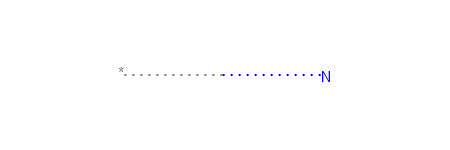

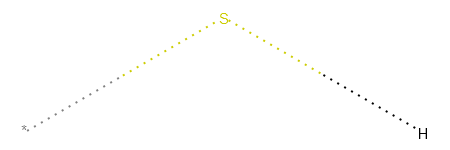

(None, None)

In [4]:
amino_pattern = Chem.MolFromSmarts('*[NH2]')
thiol_pattern = Chem.MolFromSmarts('*S[H]')
display(amino_pattern), display(thiol_pattern)

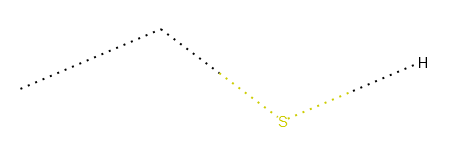

True

In [5]:
ethanethiol_pattern = Chem.MolFromSmarts('CCS[H]')
display(ethanethiol_pattern)
ethanethiol_pattern.HasSubstructMatch(thiol_pattern)

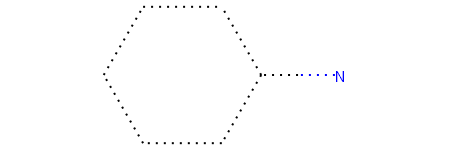

True

In [6]:
aniline_pattern = Chem.MolFromSmarts('[NH2]c1ccccc1')
display(aniline_pattern)
aniline_pattern.HasSubstructMatch(amino_pattern)

In [7]:
import itertools
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def visualize_match(structure, pattern):
    # GetSubstructMatches grabs all hits, GetSubstructMatch the first one it finds
    hits = structure.GetSubstructMatches(pattern)
    hit_atoms = set()
    hit_bonds = set()
    for hit in hits:
        hit_atoms.update(hit)
        hit_bonds.update([structure.GetBondBetweenAtoms(i, j).GetIdx()
                          for i, j in itertools.combinations(hit_atoms, 2)
                          if structure.GetBondBetweenAtoms(i, j)])
    d = rdMolDraw2D.MolDraw2DSVG(300,300)
    rdMolDraw2D.PrepareAndDrawMolecule(d, structure, highlightAtoms=hit_atoms, highlightBonds=hit_bonds)
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))

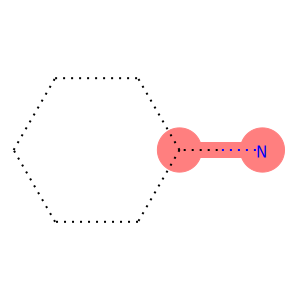

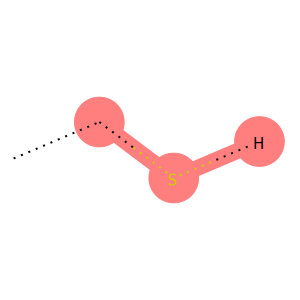

(None, None)

In [8]:
visualize_match(aniline_pattern, amino_pattern), visualize_match(ethanethiol_pattern, thiol_pattern), 

### Seems like the substructure matching works. Now I am going to try it on my DRD1 dataset

In [9]:
nh2_counts_drd1 = [len(m.GetSubstructMatches(amino_pattern)) for m in drd1_ligands]
nh2_counts_drd1_nonzero = [m for m in nh2_counts_drd1 if m]
print("all ligands:", len(nh2_counts_drd1))
print("with NH1 group:", len(nh2_counts_drd1_nonzero))
print("approximate number of NH2 groups on molecule with it:", sum(nh2_counts_drd1_nonzero)/len(nh2_counts_drd1_nonzero))
print("maximum number of NH2 groups on one molecule:", max(nh2_counts_drd1_nonzero))

all ligands: 1042
with NH1 group: 191
approximate number of NH2 groups on molecule with it: 1.4031413612565444
maximum number of NH2 groups on one molecule: 11


In [10]:
sh_counts_drd1 = [len(m.GetSubstructMatches(thiol_pattern)) for m in drd1_ligands]
sh_counts_drd1_nonzero = [m for m in sh_counts_drd1 if m]
print("all ligands:", len(sh_counts_drd1))
print("with SH group:", len(sh_counts_drd1_nonzero))

all ligands: 1042
with SH group: 0


Interesting - there are 191 ligands with NH2 group and 0 ligands with thiol group.

### Let's visualise some of the molecules with NH2 to see what they look like.

In [11]:
nh2_ligands = [m for m, i in zip(drd1_ligands, nh2_counts_drd1) if i > 0]
print("control sum:", len(nh2_ligands))

control sum: 191


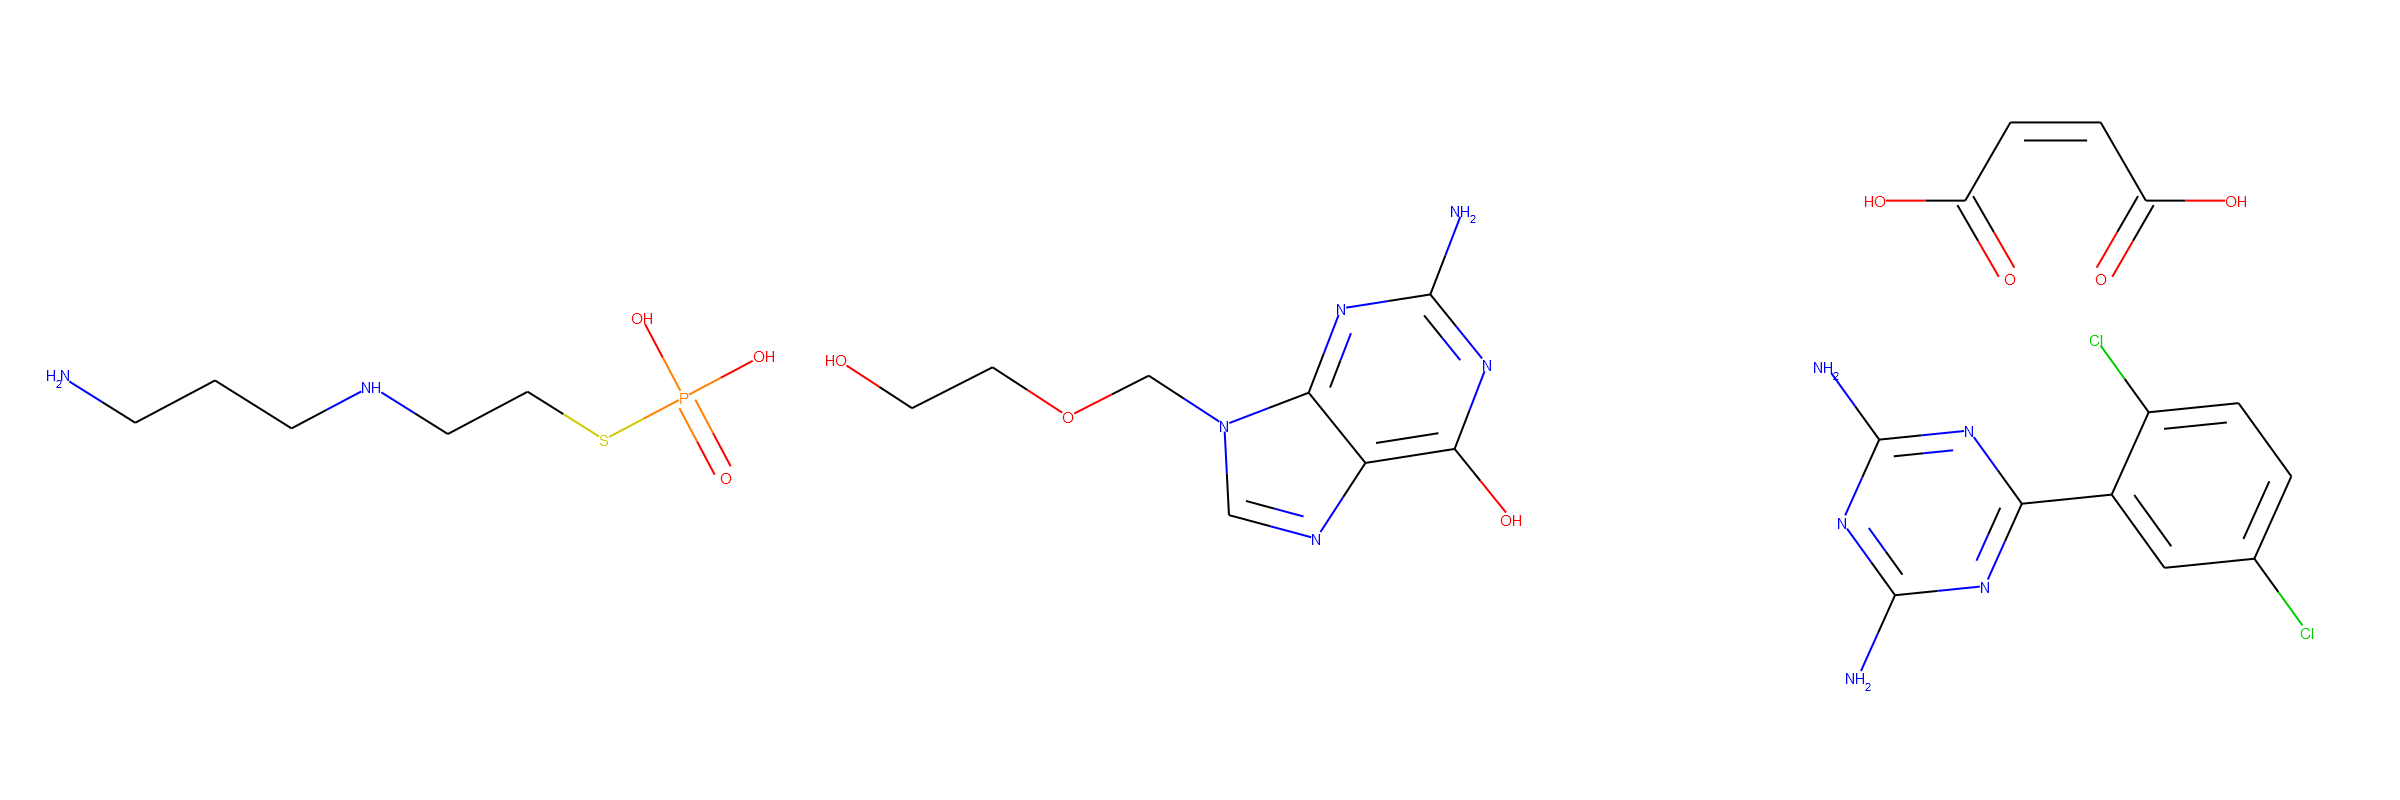

In [12]:
Draw.MolsToGridImage([nh2_ligands[m] for m in [0,8,100]], molsPerRow=3, subImgSize=(800,800))

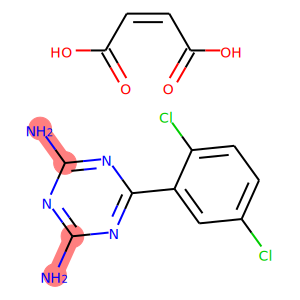

In [13]:
visualize_match(nh2_ligands[100], amino_pattern)

### Vizualisation of molecule with the most NH2 groups (only one, with 11)

In [14]:
lots_of_nh2 = [m for m, i in zip(drd1_ligands, nh2_counts_drd1) if i == 11]
len(lots_of_nh2)

1

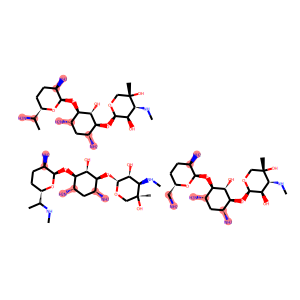

In [15]:
super_molecule = lots_of_nh2[0]
visualize_match(super_molecule, amino_pattern)

This looks like three different molecules together

# PAINS
In addition to our custom queries, there are also established lists of substructures put together for a specific purpose. Widely used, and widely discussed are the PAINS, or [PAn -Assay INterference compoundS](https://www.nature.com/news/chemistry-chemical-con-artists-foil-drug-discovery-1.15991). These are structural patterns that are known to interfere with the mechanism of assays used to screen for substances with a desired biological activity. These structures are likely to come up as false positivies in assays, and might become a trap that consumes time and resources of those unfamiliar with those factors. As always in cheminformatics, PAINS are not a panacea and should be used [with care](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5778390/). They are definitively red flags, though, and you should be definitely aware of them. As shown in the Nature article:

![PAINS](../data/pix/pains.jpg)
![PAINS2](../data/pix/pains2.jpg)

Let's load up some of those PAINS, and see whether your sets of ligands have any of them :)

In [16]:
from itertools import chain
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append([Chem.MolFromSmarts(pattern),
                      text.lstrip("<regId=\"").rstrip("\">")]) # remove the xml tags
# pains 
len(pains)

425

So, we have parsed over 400 known PAINS, in a list of (pattern, patternname) pairs. Let's scan my DRD1 set. Substruct search is expensive, so it might take a while :)

In [17]:
for m in drd1_ligands: # for each ligand
    # add a variable that stores indices of all PAINS patterns that match it
    m.pain_hits = [i for i, pain in enumerate(pains) if m.HasSubstructMatch(pain[0])]

drd1_with_pains = [m for m in drd1_ligands if m.pain_hits]
drd1_with_pains, len(drd1_with_pains)

([<rdkit.Chem.rdchem.Mol at 0x26182e9a620>,
 24)

Apparently, there are 24 structures with PAINS among the KNOWN ligands. Let's have a closer look:

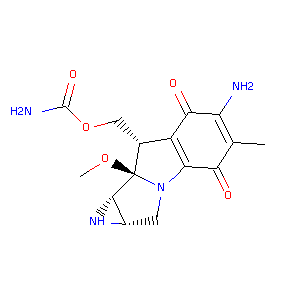

In [18]:
Draw.MolToImage(drd1_with_pains[0])

What PAINS did the first one trigger?

In [19]:
drd1_with_pains[0].pain_hits, pains[drd1_with_pains[0].pain_hits[0]]

([413], [<rdkit.Chem.rdchem.Mol at 0x2618fe61f30>, 'quinone_A(370)'])

PAINS pattern with index 413, quinone_A.

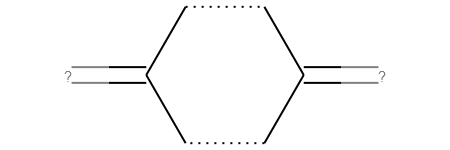

In [20]:
pains[drd1_with_pains[0].pain_hits[0]][0]

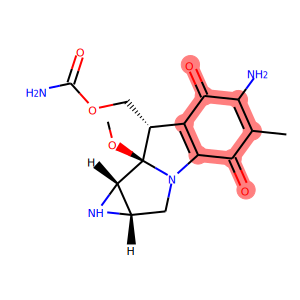

In [21]:
visualize_match(drd1_with_pains[0], pains[drd1_with_pains[0].pain_hits[0]][0])

Because there are not many ligands with PAINS structure, we can filter them away.

### What types of pains are found in my DRD1 ligand dataset?

In [22]:
pains_types = [drd1_with_pains[x].pain_hits for x in range(len(drd1_with_pains))]
print(pains_types)

[[413], [417], [414], [10], [413], [418], [4], [418], [413], [10], [413], [413], [419], [414], [413], [4], [418], [414], [413], [413], [413], [185], [414], [414]]


In [23]:
from itertools import chain
unique = set(list(chain(*pains_types)))
unique

{4, 10, 185, 413, 414, 417, 418, 419}

In [24]:
pains_names = [[number, pains[number]] for i, number in enumerate(unique)]
pains_names

[[417, [<rdkit.Chem.rdchem.Mol at 0x2618fe66170>, 'anil_di_alk_B(251)']],
 [418, [<rdkit.Chem.rdchem.Mol at 0x2618fe66210>, 'anil_di_alk_C(246)']],
 [419, [<rdkit.Chem.rdchem.Mol at 0x2618fe66260>, 'ne_rhod_A(235)']],
 [4, [<rdkit.Chem.rdchem.Mol at 0x2618fe48210>, 'styrene_A(13)']],
 [10, [<rdkit.Chem.rdchem.Mol at 0x2618fe48530>, 'keto_keto_beta_B(12)']],
 [185, [<rdkit.Chem.rdchem.Mol at 0x2618fe54b70>, 'steroid_A(2)']],
 [413, [<rdkit.Chem.rdchem.Mol at 0x2618fe61f30>, 'quinone_A(370)']],
 [414, [<rdkit.Chem.rdchem.Mol at 0x2618fe66030>, 'azo_A(324)']]]

There are 8 types of PAINS in my whole ligand dataset. They are found in 24 molecules. As 24 is not that many (out of 1042 molecules), we can filter them out.

### filtering molecules with PAINS substructure out of the DRD1 ligand dataset:

In [25]:
drd1_ligands_new = [m for m in drd1_ligands if m not in drd1_with_pains]
print("DRD1 without PAINS:", len(drd1_ligands_new))
print("DRD1 with PAINS:", len (drd1_with_pains))
print("control sum okay:", (len(drd1_ligands_new) + len (drd1_with_pains)) == len(drd1_ligands))

DRD1 without PAINS: 1018
DRD1 with PAINS: 24
control sum okay: True


### saving the filtered set of ligands to a new file: